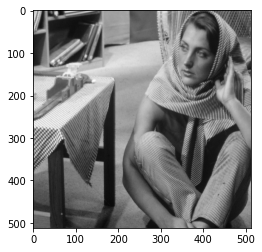

In [1]:
import os 
os.chdir(r"E:\ENMARTZ\SEMESTRE 10\Optimización Convexa\Proyecto\admm-matrix-completion")
# os.chdir(r"G:\Mi unidad\2021-I\optimizacion\admm-matrix-completion")

from data import load_gif_data
from core.utils import Mask
    
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)

DATA_DIR = "imgs/validation"
dataset = load_gif_data(DATA_DIR) / 255
img = dataset[0]

plt.imshow(img, cmap='gray')

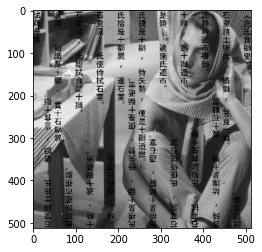

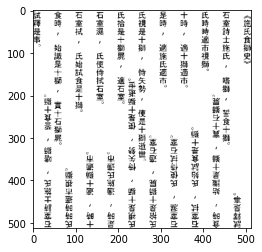

In [2]:
MODE = "text"
mask = Mask(mode=MODE, prcnt=0.5)

corrupted , mask = mask(img)
plt.imshow(corrupted, cmap='gray')
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

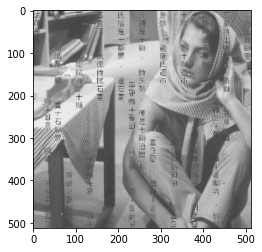

In [3]:
import bm3d

denoised = bm3d.bm3d(corrupted, sigma_psd=np.std(mask), stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
plt.imshow(denoised*(1-mask)+ corrupted, cmap='gray')

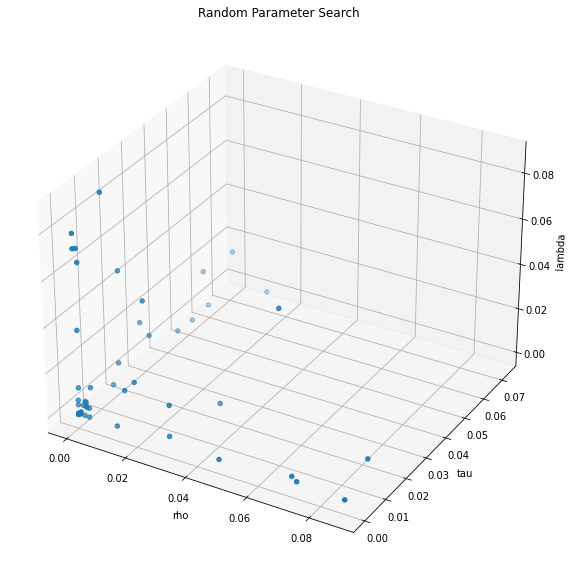

In [4]:
# Random parameter search. https://napsterinblue.github.io/notes/machine_learning/model_selection/random_search/

# log scale

min_exp, max_exp = -5, -1

np.random.seed(5)
rhos = 10 ** np.random.uniform(min_exp, max_exp, size=50)
taus = 10 ** np.random.uniform(min_exp, max_exp, size=50)
lams = 10 ** np.random.uniform(min_exp, max_exp, size=50)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(rhos, taus, lams)
ax.set_title('Random Parameter Search')
ax.set_xlabel('rho')
ax.set_ylabel('tau')
ax.set_zlabel('lambda')

fig.savefig("imgs/random_parameter_search.png", dpi=400)

In [5]:
# best parameters
idx = 47

best_rho = rhos[idx]
best_tau = taus[idx]
best_lam = lams[idx]

Iteration [100 / 100] rho: 0.000394 tau: 1.2e-05 lambda: 0.000162: 100%|██████████| 100/100 [12:58<00:00,  7.78s/it, frob=3.87, psnr=42.4, ssim=0.99]

iteration 100 | error 3.87 | psnr 42.42 | ssim 0.99 | time 7.8825
Fin :3


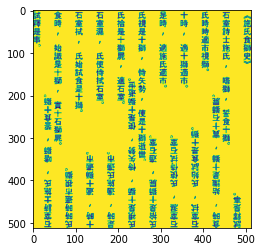

In [17]:
# from itertools import product
from core.admm_v2 import ADMM

iters = 100
# mask_names = ["random", "text", "irregular"]
# mask_names = ["irregular"]
mask_names = ["random", "text"]

for mask_name in mask_names:

    history = []
    path = f'results_2/exp_{idx}_mask_{mask_name}_rho_{np.round(best_rho, 6)}_best_tau_{np.round(best_tau, 6)}_lambda_{np.round(best_lam, 6)}.txt'

    for img in dataset:

        params = dict(rho=best_rho,
                    tau=best_tau,
                    lambd=best_lam,
                    iters=iters
                    )

        mask = Mask(mode=mask_name, prcnt=0.5)
        corrupted, mask = mask(img)

        plt.imshow(mask)

        admm = ADMM()
        estimated, hist = admm.restore(corrupted, mask, sol=img, **params)
        history.append(hist)

    # save history

    with open(path, "w") as txt:
        txt.write("#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#\n")
        txt.write("      Model configuration and hyperparameters      \n")
        txt.write("#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#\n")
        txt.write(f"mask_{mask_name}\tbest_rho_{best_rho}\tbest_tau_{best_tau}\tbest_lambda_{best_lam}\n")
        for his in history:
            pos = np.argmax(his["psnr"])
            frob, psnr, ssim = his["frob"][pos], his["psnr"][pos], his["ssim"][pos]
            txt.write(f'frob={frob}\tpsnr={psnr}\tssim={ssim}\n')
        txt.write('Promedio:\n')
        mean_frob, mean_psnr, mean_ssim = np.mean( his["frob"]), np.mean( his["psnr"]), np.mean( his["ssim"])
        txt.write(f'frob={mean_frob}\tpsnr={mean_psnr}\tssim={mean_ssim}\n')

    # save history

    for i, his in enumerate(history):
        np.save('history/' + str(i) + '_mask_' + mask_name + '.npy', np.array([his["frob"], his["psnr"], his["ssim"]]))



# # plot performance vs epoch

# fig, ax = plt.subplots(1, 3, figsize=(10, 20))

# ax[0].plot(np.array(frob_list))
# ax[0].set_title("Frobenius Error")
# ax[0].set_xlabel("Epochs")
# ax[1].imshow(np.array(psnr_list))
# ax[1].set_title("PSNR")
# ax[1].set_xlabel("Epochs")
# ax[2].imshow(np.array(ssim_list))
# ax[2].set_title("SSIM")
# ax[2].set_xlabel("Epochs")
# # plt.show()

# plt.savefig(debug_dir + "imgs/epochs")

print('Fin :3')


In [8]:
np.array([history[0]["frob"], history[0]["psnr"], history[0]["ssim"]])

array([[42.79, 84.75],
       [21.56, 15.62],
       [ 0.86,  0.84]])

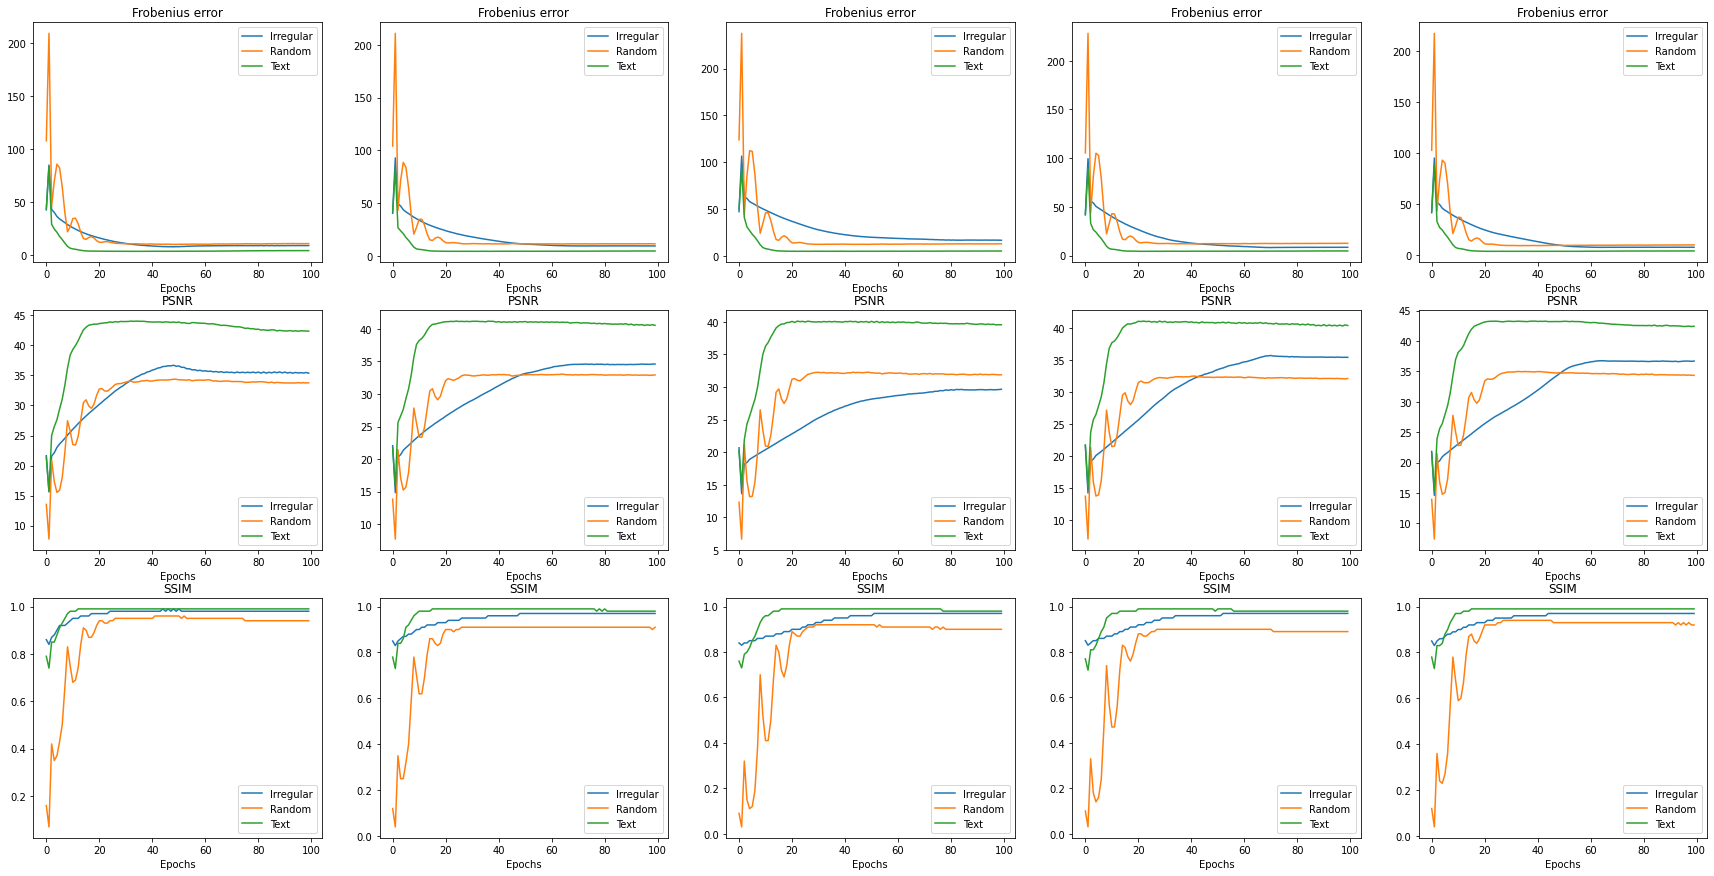

In [46]:
fig, ax = plt.subplots(3, 5, figsize=(30, 15))

for i in range(5):
    histor_ir = np.load('history/' + str(i) + '_mask_irregular.npy')
    histor_ra = np.load('history/' + str(i) + '_mask_random.npy')
    histor_te = np.load('history/' + str(i) + '_mask_text.npy')

    ax[0, i].plot(np.vstack([histor_ir[0], histor_ra[0], histor_te[0]]).T)
    ax[0, i].set_title('Frobenius error')
    ax[0, i].set_xlabel('Epochs')
    ax[0, i].legend(['Irregular', 'Random', 'Text'])

    ax[1, i].plot(np.vstack([histor_ir[1], histor_ra[1], histor_te[1]]).T)
    ax[1, i].set_title('PSNR')
    ax[1, i].set_xlabel('Epochs')
    ax[1, i].legend(['Irregular', 'Random', 'Text'])

    ax[2, i].plot(np.vstack([histor_ir[2], histor_ra[2], histor_te[2]]).T)
    ax[2, i].set_title('SSIM')
    ax[2, i].set_xlabel('Epochs')
    ax[2, i].legend(['Irregular', 'Random', 'Text'])

plt.savefig("imgs/epochs", dpi=400)

In [29]:
np.vstack([histor_ir[1], histor_ra[1], histor_te[1]]).shape

(3, 100)

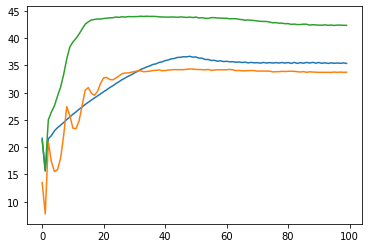

In [31]:
#plt.plot(history[0]["frob"])

#plt.plot(history[0]["ssim"])

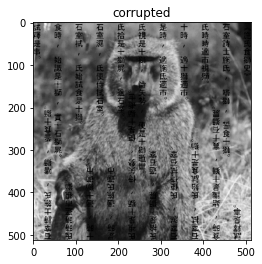

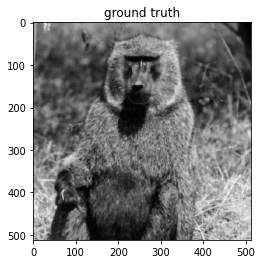

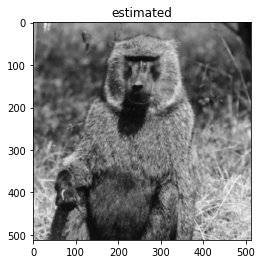

In [20]:
plt.title("corrupted")
plt.imshow(corrupted, cmap='gray')
plt.show()

plt.title("ground truth")
plt.imshow(img, cmap='gray')
plt.show()


plt.title("estimated")
plt.imshow(estimated, cmap='gray')
plt.show()

In [ ]:
# ! pip install bm3d
# ! pip install scikit-image
# ! pip install tqdm